# INM430 Principles of Data Science - Coursework
Daniel Sikar - PT1 MSc Data Science

## Determining signal processing strategies to eliminate Flame Detector analogue noise generated by GHz frequency interference

In this computational notebook, we examine and process data to support our choice of noise reduction algorithms. A total of 28 flame detector log files are examined, varying in duration, from a few seconds to five minutes. One file (Test45.log) was taken from a flame detector exposed to a real fire, while the remaining log files where taken from the same flame detector subject to RF (radio frequency) interference while was subjet the functional testing for safety level integrity.

## Data log format

The data in the flame detector log files in identified by lines containing 12 hexadecimal digits (6 columns of 1 byte), containing 6 unsigned byte values (0 to 255), e.g. **8A8B8B990045**, which would correspond to:

Byte 1 - Flame detector A (8A hexadecimal, 138 decimal)  
Byte 2 - Flame detector B (8B hexadecimal, 139 decimal)  
Byte 3 - Guard (8B hexadecimal, 139 decimal)  
Byte 4 - Flame A voltage reference (99 hexadecimal, bits 0 to 3 ~ 9) and Flame B voltage reference (bits 4 to 7 ~ 9).  
Byte 5 - not used  
Byte 6 - Alarm\Gain\0\Spike\Count\Count\Count\Count (45 hexadecimal) the binary value (bit pattern) is 01000101 meaning, Alarm = 0, Gain = 1, not used, Spike = 0, 4-bit count (0 to 15).

Each reading (data point acquisition) is taken in 10ms intervals. A flame is reported by software if the average analogue reading from any of the two flame detectors (FlameA and FlameB) is above 139, five consecutive times within a five second period. The Guard signal detects black body heat sources (such as a heater) which must not be interpreted as a fire. In the presence of such heat sources, the guard reports a higher value than the flame detectors, and the result the signal will not be interpreted as a fire.  
The voltage references are used to determine the analogue values read from Flame A and Flame B, while the flags are used to track state with every reading such as Alarm (detector raised an alarm), Gain(signal amplification level), Spike (spike detected) and rolling count (to ensure values read are continuous and none have been missed).  

## Data processing  

First we write some functions to process the logs:

In [3]:
%matplotlib inline

###########################
## PROCESS ALL LOG FILES ##
###########################

# helper functions
def getBiasVoltages(iBv):
    # Expecting a byte value e.g. 99 cast as int (153)
    FlMask = 0xF0 # mask for the flame voltage bias i.e. 11110000
    FRshift = 4 # number of right shifts e.g. start with 0x99, end with 0x09
    GMask = 0x0F # mask for the guard voltage bias, no need to shift
    iFbv = (iBv & FlMask) >> FRshift 
    iGbv = iBv & GMask 
    return iFbv, iGbv

def getAlarmGainSpikeCount(iEvent):
    # Byte 6:  EVENT (MSB-LSB: Alarm\Gain\0\Spike\Count\Count\Count\Count) -check
    # Alarm = bit 7
    # Gain = bit 6
    # Spike = bit 4
    # Count = bits 0,1,2,3
    # Notes; count is a sequential 4 bit count, expected to be continuous and
    # carry over o 15, restarting at 0. If any values are found to be missing, action
    # might be required, e.g. linear interpolation to patch missing observations
    AMask = 0x80 # 10000000
    ARshift = 7
    GMask = 0x40 # 01000000
    GRshift = 6
    SMask = 0x10 # 00010000
    SRshift = 4
    CMask = 0x0F # 00001111
    # no shift required for count
    Alarm = (iEvent & AMask) >> ARshift
    Gain = (iEvent & GMask) >> GRshift
    Spike = (iEvent & SMask) >> SRshift
    Count = (iEvent & CMask)
    return Alarm, Gain, Spike, Count

def processLog(filePath, filename):
    # expected return values are
    # FlameA, FlameB, Guard, Flame A&B bias voltage, Alarm (true/false), Gain(true/false)
    # Spike(true/false) and Count(4 bit running count)
    import numpy as np
    # vars
    # expected record length
    iRecLen = 12
    # initialise empty return array
    retarr = np.empty((0,9), dtype='uint8')

    logfilename = filePath + filename
    file = open(logfilename, "r")
    for line in file:
        line = line.rstrip()
        if((len(line) == iRecLen) & (line.find(" ") < 0)):
            # FlameA, FlameB and Guard detector analogue readings
            iFAv = int(line[0:2], 16)
            iFBv = int(line[2:4], 16)
            iG = int(line[4:6], 16)
            iBv = int(line[6:8], 16)
            iFbv, iGbv = getBiasVoltages(iBv)
            iEvent = int(line[10:12], 16)
            Alarm, Gain, Spike, Count = getAlarmGainSpikeCount(iEvent)            
            retarr = np.append(retarr, [[iFAv, iFBv, iG, iFbv, iGbv, Alarm, Gain, Spike, Count]],axis = 0)
    return retarr

def getLogfiles(path, pattern):
    # return a list of files
    import glob
    files = []
    for name in glob.glob(path + pattern):
        files.append(name[len(path):])
    return files

def gainPolygon(farr, plt):
    Sidx = 6 # gain flag index
    iSize = farr[0:,0].size 
    # y axys polygon edges
    maxY = np.max([np.max(farr[:,0]), np.max(farr[:,1])])
    # show gain on the lower part of the plot
    maxY = int(maxY/8)
    minY = np.min([np.min(farr[:,0]), np.min(farr[:,1])])
    yPol = [minY,maxY,maxY,minY]
    for i in range(iSize):
        # check if Alarm polygon needs to be plotted
        if ((farr[i,Sidx] == 1) & ((i+1) <= iSize)):
            xPol = [i, i, i+1, i+1]
            # greenish colour
            plt.fill(xPol, yPol, '#02fe02')

def spikePolygon(farr, plt):
    Sidx = 7 # spike flag index
    iSize = farr[0:,0].size 
    # y axys polygon edges
    maxY = np.max([np.max(farr[:,0]), np.max(farr[:,1])])
    minY = np.min([np.min(farr[:,0]), np.min(farr[:,1])])
    yPol = [minY,maxY,maxY,minY]
    for i in range(iSize):
        # check if Alarm polygon needs to be plotted
        if ((farr[i,Sidx] == 1) & ((i+1) <= iSize)):
            xPol = [i, i, i+1, i+1]
            plt.fill(xPol, yPol, '#0200fe')
            
def alarmPolygon(farr, plt):
    Aidx = 5 # alarm flag index
    iSize = farr[0:,0].size 
    # y axys polygon edges
    #maxY = np.max(farr[:,0])
    #minY = np.min(farr[:,0])
    maxY = np.max([np.max(farr[:,0]), np.max(farr[:,1])])
    minY = np.min([np.min(farr[:,0]), np.min(farr[:,1])])    
    yPol = [minY,maxY,maxY,minY]
    for i in range(iSize):
        # check if Alarm polygon needs to be plotted
        if ((farr[i,Aidx] == 1) & ((i+1) <= iSize)):
            xPol = [i, i, i+1, i+1]
            plt.fill(xPol, yPol, '#fe0002')

def plotFlamedata(farr, file):
    %matplotlib inline
    import matplotlib.pyplot as plt
    import numpy as np
    # indices
    FAidx = 0
    FBidx = 1
    Gidx = 2
    # x axis time series array
    iIdx = np.arange(1, farr[:,0].size + 1, 1) # iIdx = np.arange(1, iGlfd.size + 1, 1)
    plt.clf()
    figWidthScale = 66 # 1150 points for every 18 inches
    figHeight = 10
    figWidth = farr[:,FAidx].size / figWidthScale # about 484 inches for a 30 second capture
    plt.figure(figsize=(figWidth,figHeight))
    plt.plot(iIdx, farr[:,FAidx], label='FlameA')
    plt.plot(iIdx, farr[:,FBidx], label='FlameB')
    plt.plot(iIdx, farr[:,Gidx], label='Guard')
    # fill spike state indicator bar
    spikePolygon(farr, plt)
    # Fill Alarm state indicator bar
    alarmPolygon(farr, plt) 
    # Fill Gain state indicator bar
    # Gain data is not telling us much so we'll leave it out
    # gainPolygon(farr, plt)     
    plt.xlabel('Time(ms)')
    plt.ylabel('AD values')
    plt.title("Flame data - " + file)
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=1)
    # scale y 0 to 255
    plt.ylim(0, 255)
    plt.show()     

Next we plot Flame A, Flame B and Guard, plus the Spike and Alarm flags. The first plot being a real fire, all following logs being RF intereference. When the alarm flag is set a red polygon is plotted. When the spike flag is set, a blue polygon is plotted.

<Figure size 432x288 with 0 Axes>

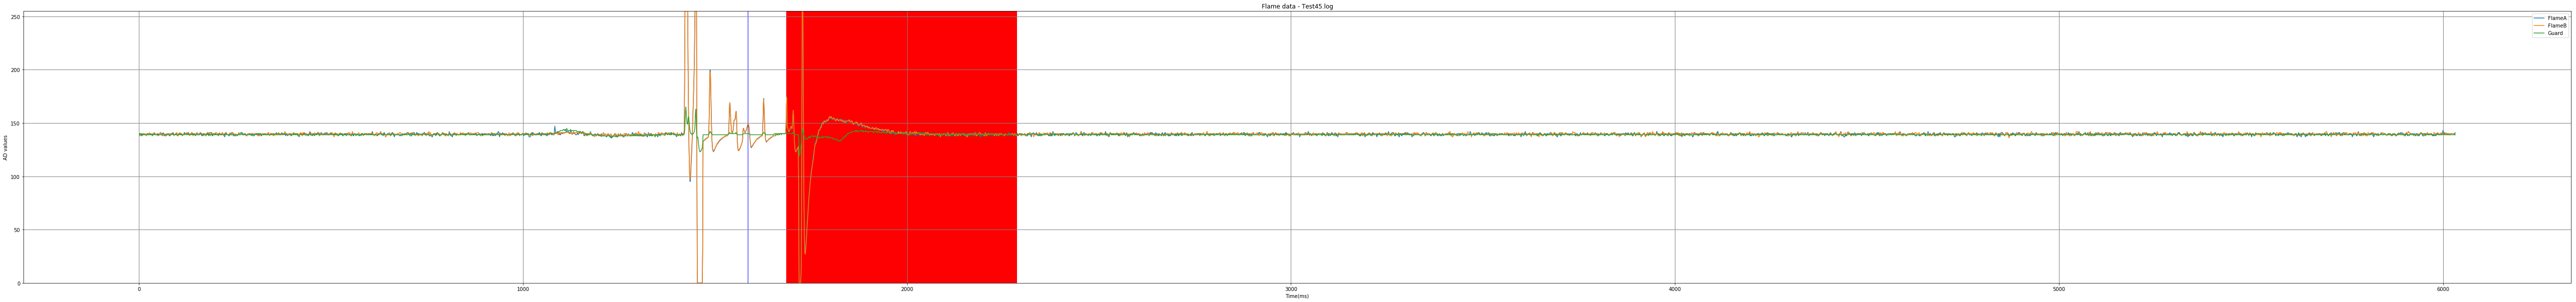

<Figure size 432x288 with 0 Axes>

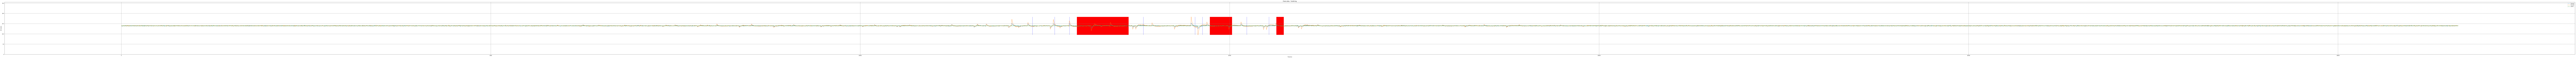

<Figure size 432x288 with 0 Axes>

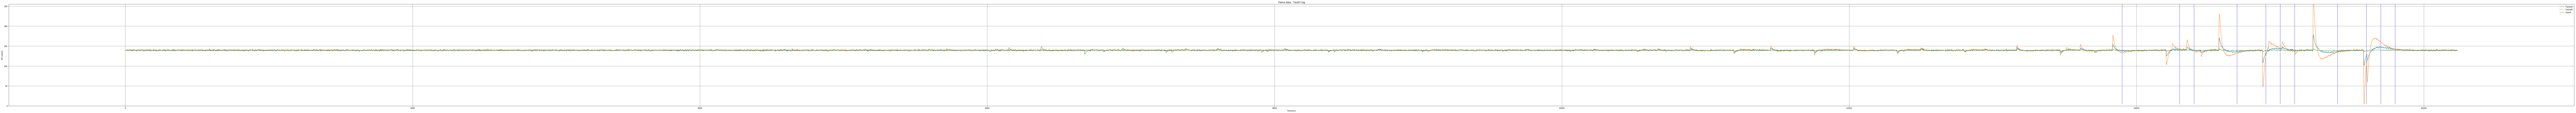

<Figure size 432x288 with 0 Axes>

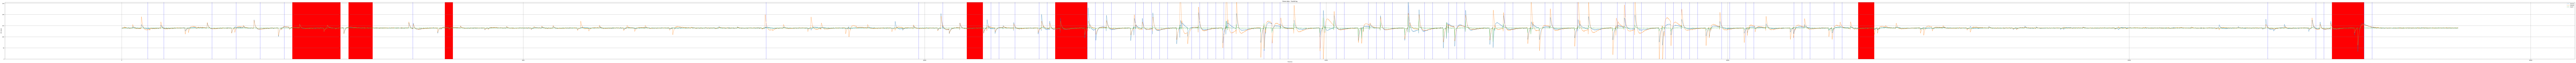

<Figure size 432x288 with 0 Axes>

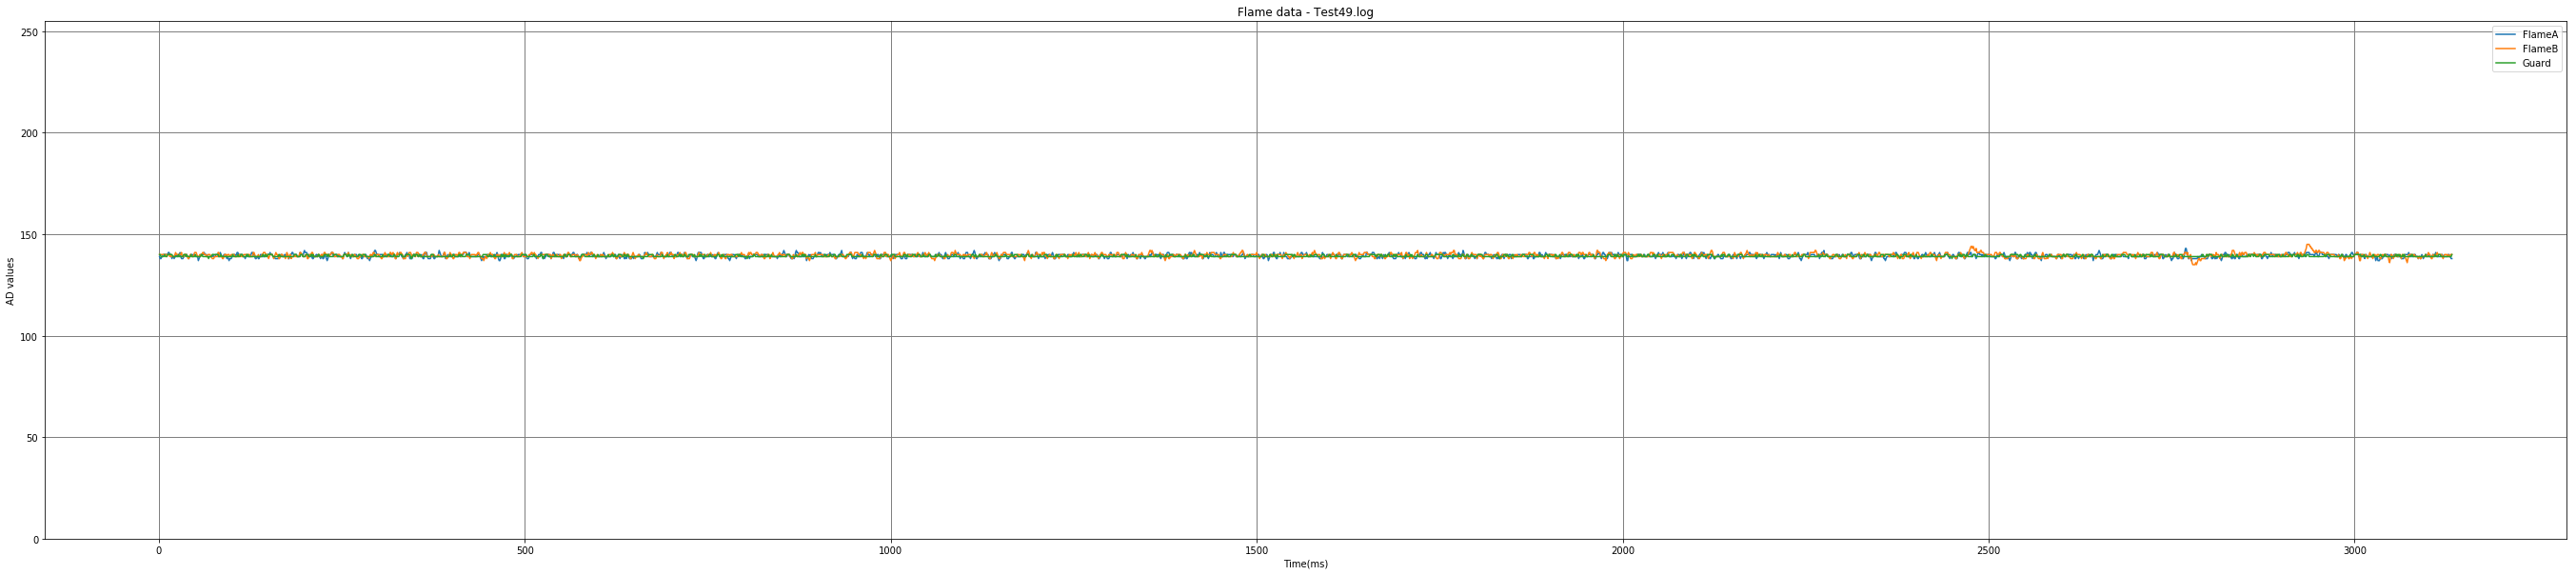

<Figure size 432x288 with 0 Axes>

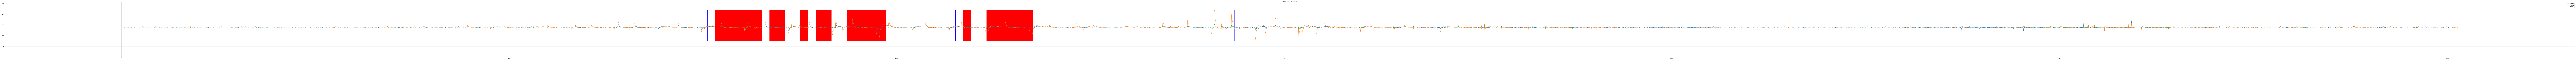

<Figure size 432x288 with 0 Axes>

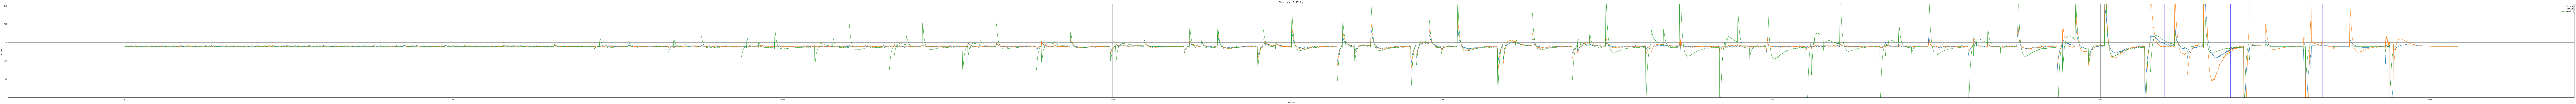

<Figure size 432x288 with 0 Axes>

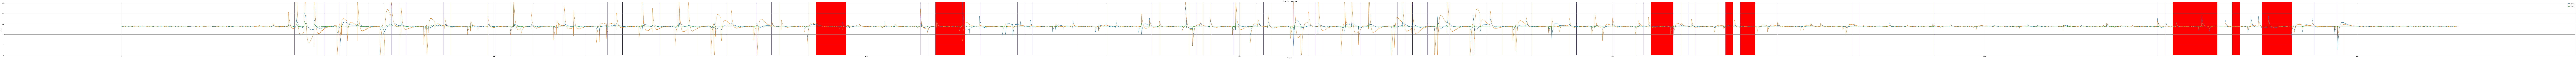

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
path = "data/full-set/"
pattern = "*.log"
# pattern = "Test45.log"
logs = getLogfiles(path, pattern)
for log in logs:
    arr = processLog(path, log)
    plotFlamedata(arr, log)
    # save
    # np.savetxt(path + log + '.csv', arr, delimiter=',')

# TODOS
* Scale Y axis to 255
* Add engineered feature (distance function)
